In [8]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [1]:
#Requirements
#!pip install pandas matplotlib seaborn nltk numpy scikit-learn networkx wordcloud matplotlib-venn

In [2]:
#Imports
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import networkx as nx
from itertools import combinations
from collections import Counter
from matplotlib_venn import venn2

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

Loading the data

In [24]:

# Define the absolute paths to the data files
youtube_file_path = '/content/drive/MyDrive/Assignment 2 code/Assignment 2/cleaned_youtube_data.json'
reddit_file_path = '/content/drive/MyDrive/Assignment 2 code/Assignment 2/cleaned_reddit_data.json'

# Verify if the files exist
import os

if os.path.exists(youtube_file_path):
    print(f"YouTube data file found at: {youtube_file_path}")
else:
    raise FileNotFoundError(f"YouTube data file not found at: {youtube_file_path}")

if os.path.exists(reddit_file_path):
    print(f"Reddit data file found at: {reddit_file_path}")
else:
    raise FileNotFoundError(f"Reddit data file not found at: {reddit_file_path}")

# Load the JSON data into DataFrames
import json
import pandas as pd
from IPython.display import display  # For better display in Colab/Jupyter

# Load YouTube Data
with open(youtube_file_path, 'r') as f:
    youtube_data = json.load(f)
youtube_df = pd.DataFrame(youtube_data)
print("\nYouTube Data Loaded Successfully!")
display(youtube_df.head())  # Display the first 5 rows of YouTube data

# Load Reddit Data
with open(reddit_file_path, 'r') as f:
    reddit_data = json.load(f)
reddit_df = pd.DataFrame(reddit_data)
print("\nReddit Data Loaded Successfully!")
display(reddit_df.head())  # Display the first 5 rows of Reddit data


YouTube data file found at: /content/drive/MyDrive/Assignment 2 code/Assignment 2/cleaned_youtube_data.json
Reddit data file found at: /content/drive/MyDrive/Assignment 2 code/Assignment 2/cleaned_reddit_data.json

YouTube Data Loaded Successfully!


video_id                                              title  \
0  -DqKHc4ybFU          ai changing everything future job society   
1  0SJTB2UI2jk                 sam altman predicts ai new era job   
2  TvhBmj2RUq0  top future high paying job ai high paying job ...   
3  ghtYU2N8GxI  quotwill ai replace job exploring future workquot   
4  u0TZv-qKjVE              impact ai future job market need know   

                                         description  \
0  How AI is Changing Everything: The Future of J...   
1  In this insightful interview, Sam Altman share...   
2                                                      
3  In this video, we explore the impact of artifi...   
4  In this eye-opening video, we delve into the f...   

                          channel_title comments published_at  
0                           GyaaniBanda       []         None  
1  NeuroPrompt - AI Future Technologies       []         None  
2                  HK Nextgen Education       []         None  
3                                   Ask       []         None  
4                       Real World Vidz       []         None


Reddit Data Loaded Successfully!


title  score  num_comments  \
0                           ownership job left futur      0            10   
1  discussioncriticism ultra sketicistism regardi...      0            18   
2  chance gen x millennials could live beyond tha...      0           112   
3  feel like military future start hiring gamers ...      0            71   
4  many change last decade much opportunity lost ...      7            27   

         created                                           selftext  \
0  1729126284000  thinking future ownership ai robotics poised b...   
1  1729014060000  greeting salutation fellow future thinking peo...   
2  1728691265000  rapid advancement medical technology like gene...   
3  1728483810000  flair military chose discussion flair tends co...   
4  1728324283000  crypto nfts pharmaceutical ai people jumping g...   

   title_length  selftext_length  engagement  
0            24              574        0.00  
1            93             9326        0.00  
2            77              464        0.00  
3            83              700        0.00  
4            86              180        0.25

Defining a simple Preprocess_Text Function (Majority of the Cleaning is Already Done)

In [25]:
# Text Preprocessing Function
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and non-alphabetic tokens
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    # Rejoin words
    return ' '.join(tokens)

# Processing Reddit Data

##### Minor Preprocessing

Combine Title and Selftext into a New Column 'Text'

In [26]:
# Combine title and selftext
reddit_df['text'] = reddit_df['title'] + ' ' + reddit_df['selftext']
reddit_df.head()

title  score  num_comments  \
0                           ownership job left futur      0            10   
1  discussioncriticism ultra sketicistism regardi...      0            18   
2  chance gen x millennials could live beyond tha...      0           112   
3  feel like military future start hiring gamers ...      0            71   
4  many change last decade much opportunity lost ...      7            27   

         created                                           selftext  \
0  1729126284000  thinking future ownership ai robotics poised b...   
1  1729014060000  greeting salutation fellow future thinking peo...   
2  1728691265000  rapid advancement medical technology like gene...   
3  1728483810000  flair military chose discussion flair tends co...   
4  1728324283000  crypto nfts pharmaceutical ai people jumping g...   

   title_length  selftext_length  engagement  \
0            24              574        0.00   
1            93             9326        0.00   
2            77              464        0.00   
3            83              700        0.00   
4            86              180        0.25   

                                                text  
0  ownership job left futur thinking future owner...  
1  discussioncriticism ultra sketicistism regardi...  
2  chance gen x millennials could live beyond tha...  
3  feel like military future start hiring gamers ...  
4  many change last decade much opportunity lost ...

Applying the Preprocess function

In [27]:
reddit_df['clean_text'] = reddit_df['text'].apply(preprocess_text)
reddit_df.head()

title  score  num_comments  \
0                           ownership job left futur      0            10   
1  discussioncriticism ultra sketicistism regardi...      0            18   
2  chance gen x millennials could live beyond tha...      0           112   
3  feel like military future start hiring gamers ...      0            71   
4  many change last decade much opportunity lost ...      7            27   

         created                                           selftext  \
0  1729126284000  thinking future ownership ai robotics poised b...   
1  1729014060000  greeting salutation fellow future thinking peo...   
2  1728691265000  rapid advancement medical technology like gene...   
3  1728483810000  flair military chose discussion flair tends co...   
4  1728324283000  crypto nfts pharmaceutical ai people jumping g...   

   title_length  selftext_length  engagement  \
0            24              574        0.00   
1            93             9326        0.00   
2            77              464        0.00   
3            83              700        0.00   
4            86              180        0.25   

                                                text  \
0  ownership job left futur thinking future owner...   
1  discussioncriticism ultra sketicistism regardi...   
2  chance gen x millennials could live beyond tha...   
3  feel like military future start hiring gamers ...   
4  many change last decade much opportunity lost ...   

                                          clean_text  
0  ownership job left futur thinking future owner...  
1  discussioncriticism ultra sketicistism regardi...  
2  chance gen x millennials could live beyond tha...  
3  feel like military future start hiring gamers ...  
4  many change last decade much opportunity lost ...

#### Word Frequency Analysis

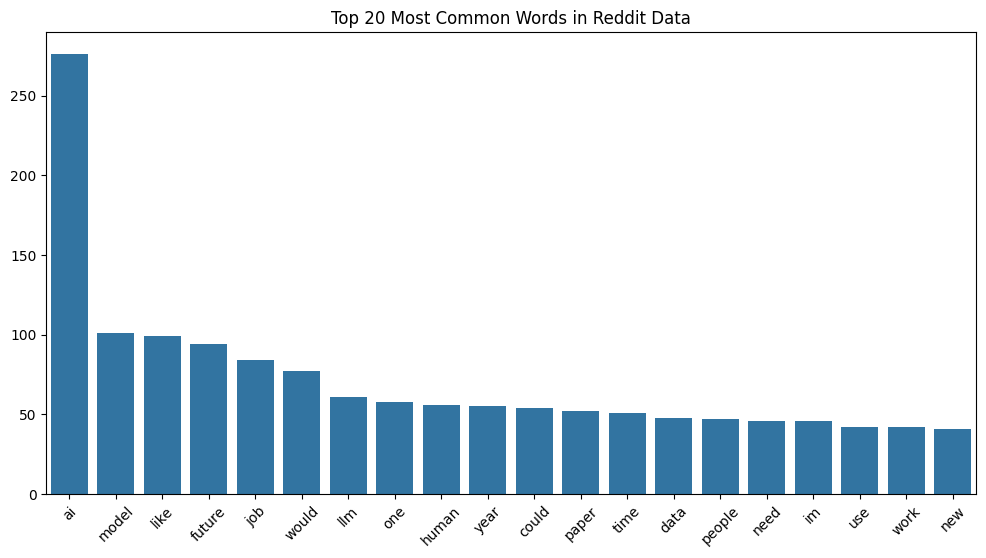

In [28]:
# Word Frequency Analysis
reddit_words = ' '.join(reddit_df['clean_text']).split()
reddit_word_freq = Counter(reddit_words)
reddit_common_words = reddit_word_freq.most_common(20)

# Plotting the most common words
words, counts = zip(*reddit_common_words)
plt.figure(figsize=(12, 6))
sns.barplot(x=list(words), y=list(counts))
plt.xticks(rotation=45)
plt.title('Top 20 Most Common Words in Reddit Data')
plt.show()

#### Generate Word Cloud

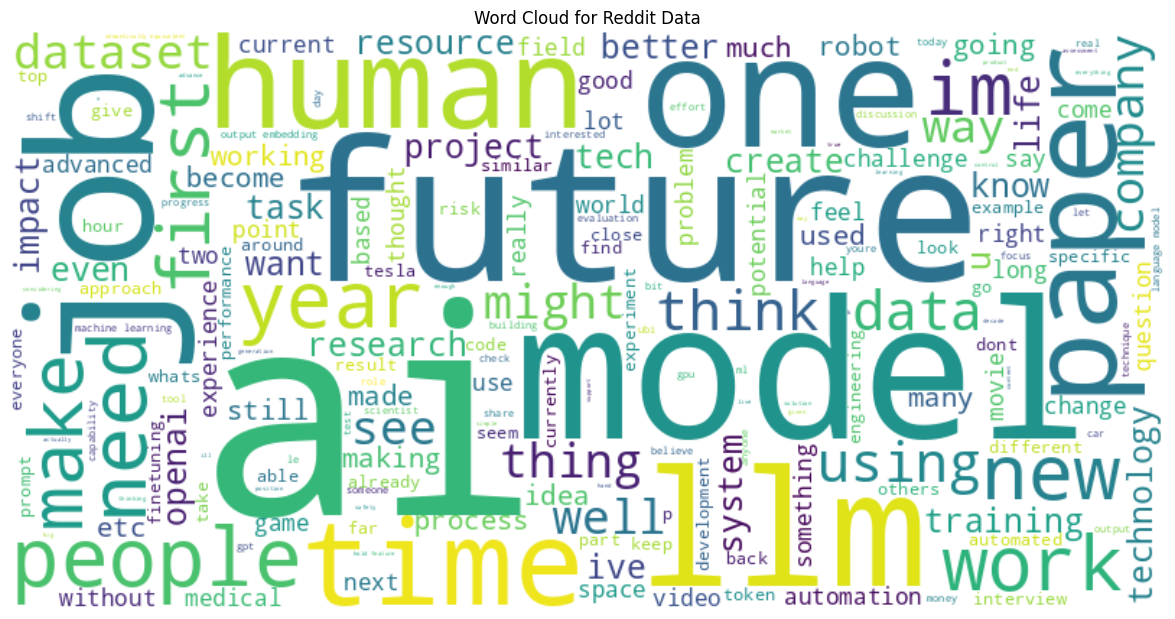

In [29]:
# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(reddit_words))
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Reddit Data')
plt.show()

#### Sentiment Analysis

Sentiment Analysis using NLTK's VADER

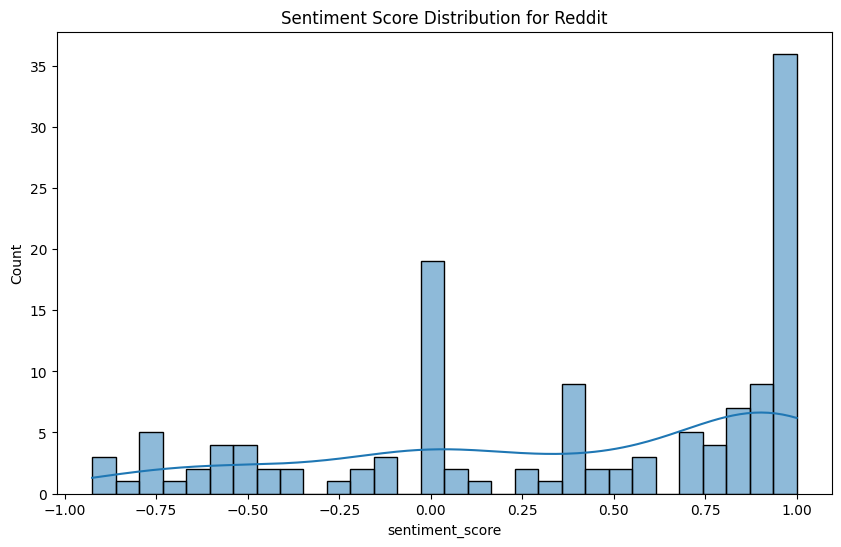

In [30]:
# Sentiment Analysis using NLTK's VADER

sia = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    return sia.polarity_scores(text)['compound']

reddit_df['sentiment_score'] = reddit_df['text'].apply(get_sentiment_score)

# Visualize sentiment distribution
plt.figure(figsize=(10, 6))
sns.histplot(reddit_df['sentiment_score'], bins=30, kde=True)
plt.title('Sentiment Score Distribution for Reddit')
plt.show()

#### Topic Modeling

Topic Modeling using LDA

In [31]:
# Vectorize the text
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
reddit_doc_term_matrix = vectorizer.fit_transform(reddit_df['clean_text'])

# LDA model
LDA = LatentDirichletAllocation(n_components=5, random_state=42)
LDA.fit(reddit_doc_term_matrix)

LatentDirichletAllocation(n_components=5, random_state=42)

In [32]:
# Display topics
print("Reddit Topics:")
for i, topic in enumerate(LDA.components_):
    topic_words = [vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-10:]]
    print(f"Top words for topic #{i}:")
    print(" ".join(topic_words))
    print("\n")

Reddit Topics:
Top words for topic #0:
time data create project medical llm like future model ai


Top words for topic #1:
data like use make learning human future im job ai


Top words for topic #2:
agi like future risk life think safety human job ai


Top words for topic #3:
language response ive model llm training paper dataset input output


Top words for topic #4:
population ai people tesla driving level year like robot car




#### Social Network Analysis (Co-occurrence Network)

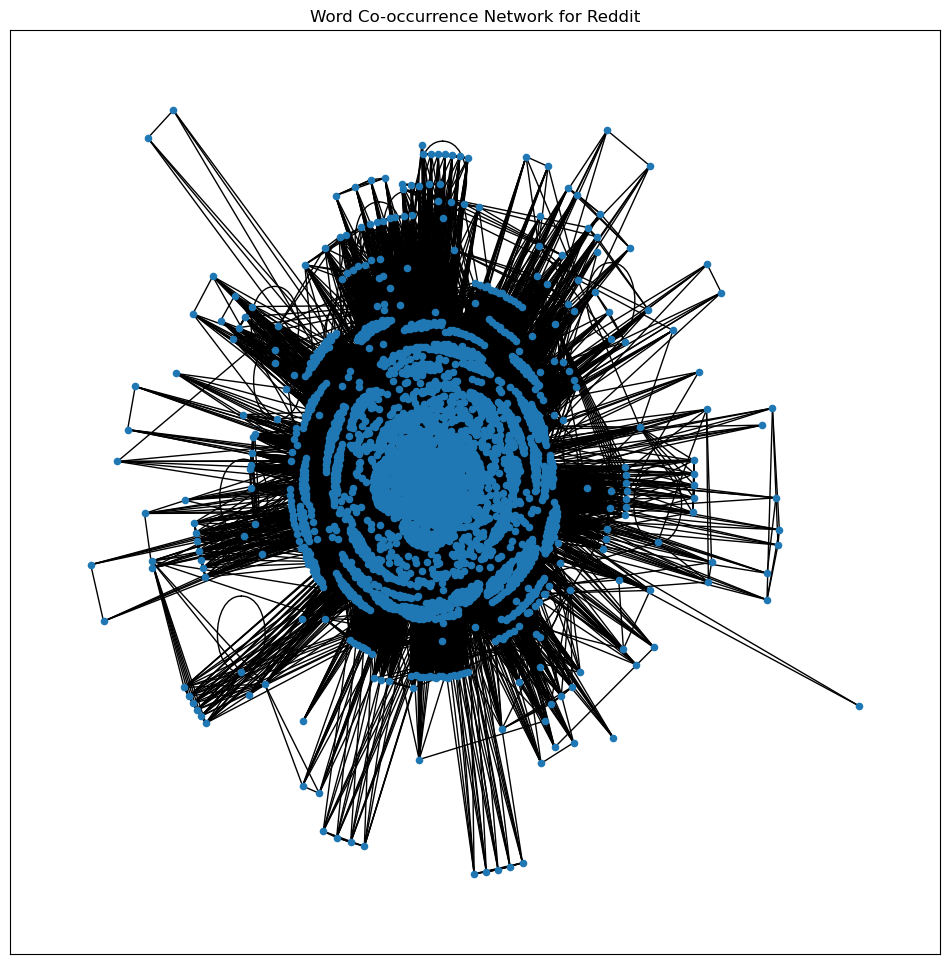

In [ ]:
# Social Network Analysis (Co-occurrence Network)
def build_co_occurrence_matrix(texts):
    vocab = set()
    for text in texts:
        vocab.update(text.split())
    vocab = list(vocab)
    vocab_index = {word: i for i, word in enumerate(vocab)}
    co_occurrence = np.zeros((len(vocab), len(vocab)))
    for text in texts:
        tokens = text.split()
        for w1, w2 in combinations(tokens, 2):
            i, j = vocab_index[w1], vocab_index[w2]
            co_occurrence[i][j] += 1
            co_occurrence[j][i] += 1
    return co_occurrence, vocab

co_occurrence_matrix, vocab = build_co_occurrence_matrix(reddit_df['clean_text'])

# Create network graph using from_numpy_array
G = nx.from_numpy_array(co_occurrence_matrix)
G = nx.relabel_nodes(G, dict(enumerate(vocab)))

# Visualize the network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.15)
nx.draw_networkx(G, pos=pos, with_labels=False, node_size=20, font_size=10)
plt.title('Word Co-occurrence Network for Reddit')
plt.show()

#### Time Series Analysis

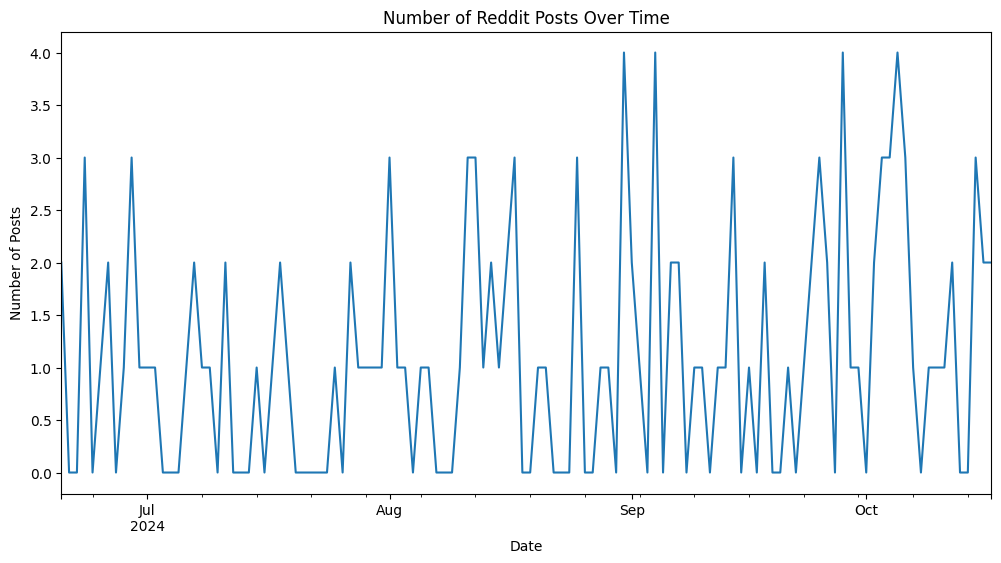

In [34]:
# Time Series Analysis
# Convert 'created' timestamps in Reddit data to datetime
reddit_df['created'] = pd.to_datetime(reddit_df['created'], unit='ms')

# Plot number of posts over time
reddit_time_series = reddit_df.set_index('created').resample('D').count()['title']

plt.figure(figsize=(12, 6))
reddit_time_series.plot()
plt.title('Number of Reddit Posts Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.show()

#### Engagement Analysis

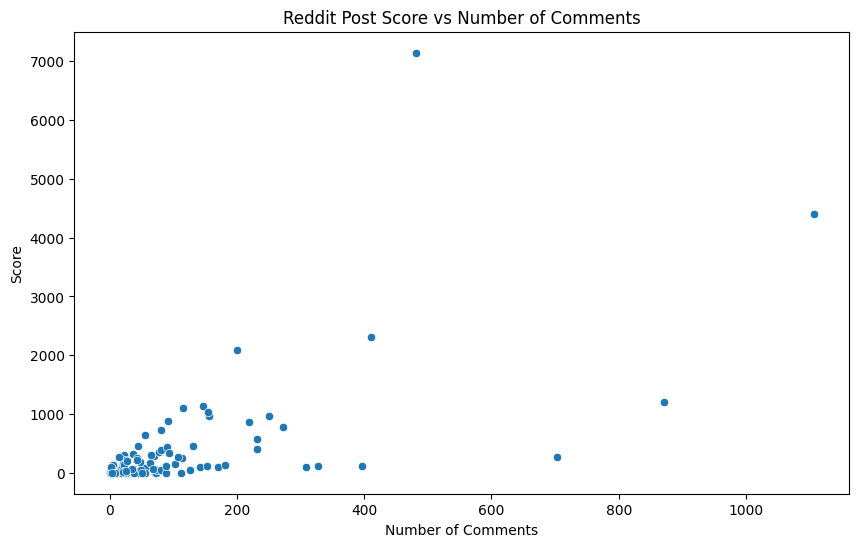

In [35]:
# Engagement Analysis
plt.figure(figsize=(10, 6))
sns.scatterplot(x='num_comments', y='score', data=reddit_df)
plt.title('Reddit Post Score vs Number of Comments')
plt.xlabel('Number of Comments')
plt.ylabel('Score')
plt.show()

# Processing YouTube Data

Extract Comments

In [36]:
# Extract comments from YouTube data
def extract_comments(data):
    comments = []
    for item in data:
        video_id = item['video_id']
        for comment in item['comments']:
            comment_text = comment['comment_text']
            comments.append({'video_id': video_id,
                             'comment_text': comment_text})
    return comments

youtube_comments = extract_comments(youtube_data)
youtube_comments_df = pd.DataFrame(youtube_comments)
youtube_comments_df.head()

video_id                                       comment_text
0  lz6Hsh4TEx4  🎬 Check out the full video here: <br><br><a hr...
1  7ZXb_nrUC28    Bro send next session of full stack development
2  7ZXb_nrUC28  Thanks for this amazing video ..<br>For AI jou...
3  7ZXb_nrUC28                                    Quality content
4  7ZXb_nrUC28  sagar sir can you say which colour theme exten...

Preprocess Text

In [37]:
youtube_comments_df['clean_text'] = youtube_comments_df['comment_text'].apply(preprocess_text)
youtube_comments_df.head()

video_id                                       comment_text  \
0  lz6Hsh4TEx4  🎬 Check out the full video here: <br><br><a hr...   
1  7ZXb_nrUC28    Bro send next session of full stack development   
2  7ZXb_nrUC28  Thanks for this amazing video ..<br>For AI jou...   
3  7ZXb_nrUC28                                    Quality content   
4  7ZXb_nrUC28  sagar sir can you say which colour theme exten...   

                                          clean_text  
0                 check full video br br https https  
1       bro send next session full stack development  
2                 thanks amazing video br ai journey  
3                                    quality content  
4  sagar sir say colour theme extension use vs co...

#### Word Frequency Analysis

In [38]:
# Word Frequency Analysis
youtube_words = ' '.join(youtube_comments_df['clean_text']).split()
youtube_word_freq = Counter(youtube_words)
youtube_common_words = youtube_word_freq.most_common(20)

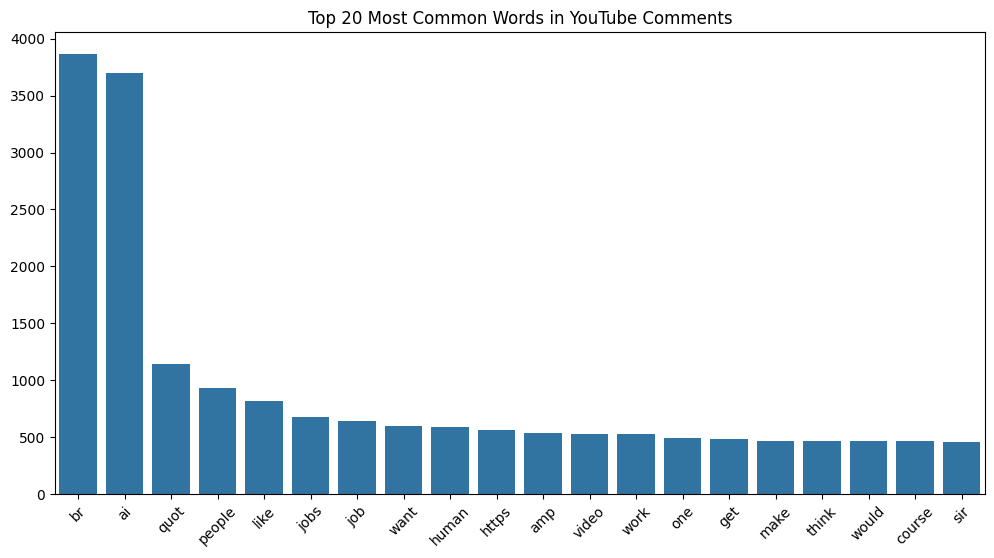

In [39]:
# Plotting the most common words
words, counts = zip(*youtube_common_words)
plt.figure(figsize=(12, 6))
sns.barplot(x=list(words), y=list(counts))
plt.xticks(rotation=45)
plt.title('Top 20 Most Common Words in YouTube Comments')
plt.show()

#### Generate Word Cloud

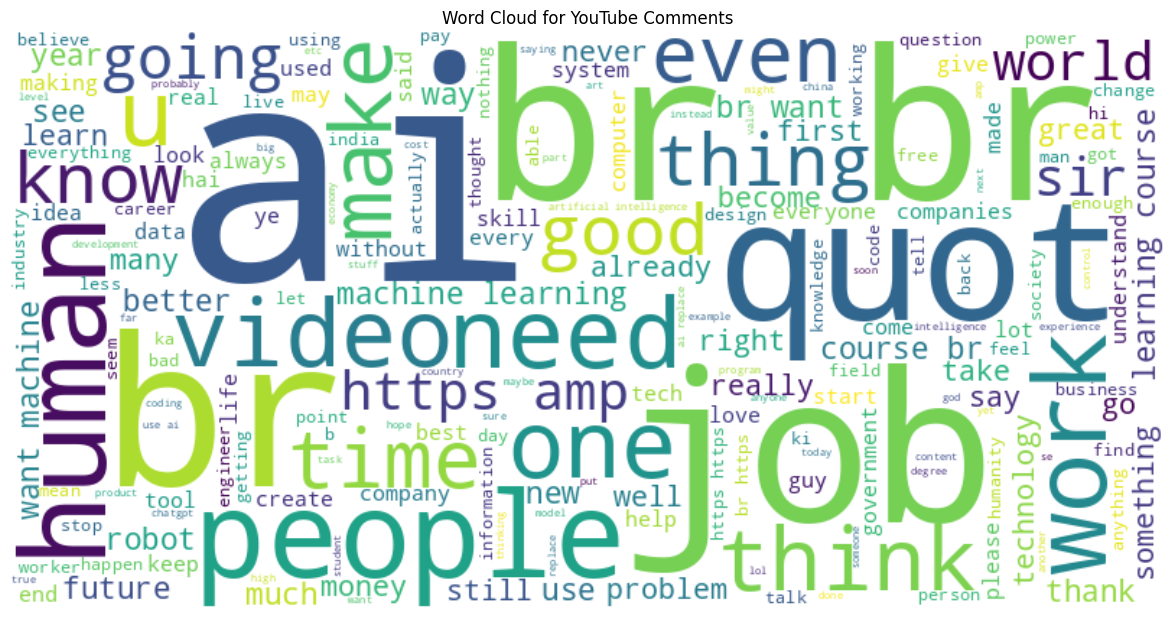

In [40]:
# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(youtube_words))
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for YouTube Comments')
plt.show()

#### Sentiment Analysis

In [41]:
# Sentiment Analysis
youtube_comments_df['sentiment_score'] = youtube_comments_df['comment_text'].apply(get_sentiment_score)

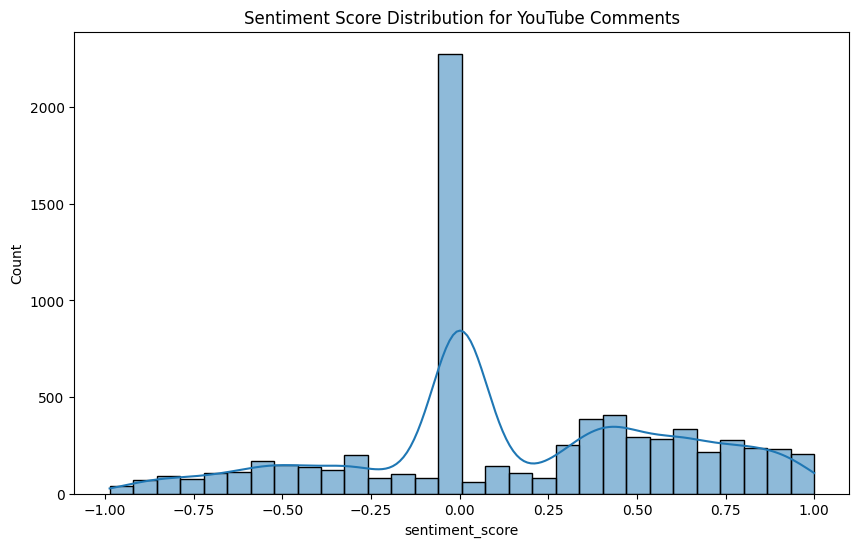

In [42]:
# Visualize sentiment distribution
plt.figure(figsize=(10, 6))
sns.histplot(youtube_comments_df['sentiment_score'], bins=30, kde=True)
plt.title('Sentiment Score Distribution for YouTube Comments')
plt.show()

#### Topic Modeling

Topic Modeling using LDA

In [43]:
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
youtube_doc_term_matrix = vectorizer.fit_transform(youtube_comments_df['clean_text'])

# LDA model
LDA = LatentDirichletAllocation(n_components=5, random_state=42)
LDA.fit(youtube_doc_term_matrix)

LatentDirichletAllocation(n_components=5, random_state=42)

In [44]:
# Display topics
print("YouTube Topics:")
for i, topic in enumerate(LDA.components_):
    topic_words = [vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-10:]]
    print(f"Top words for topic #{i}:")
    print(" ".join(topic_words))
    print("\n")

YouTube Topics:
Top words for topic #0:
free ai quot machine want learning amp course https br


Top words for topic #1:
work think value data human amp thanks like ai br


Top words for topic #2:
ke se data video ki ka job hai sir ai


Top words for topic #3:
humans need think like work human jobs people quot ai


Top words for topic #4:
great thank god people make good job like video ai




#### Social Network Analysis (Co-occurrence Network)

In [45]:
co_occurrence_matrix, vocab = build_co_occurrence_matrix(youtube_comments_df['clean_text'])

NameError: name 'build_co_occurrence_matrix' is not defined

In [ ]:
# Create network graph
G = nx.from_numpy_array(co_occurrence_matrix)
G = nx.relabel_nodes(G, dict(enumerate(vocab)))

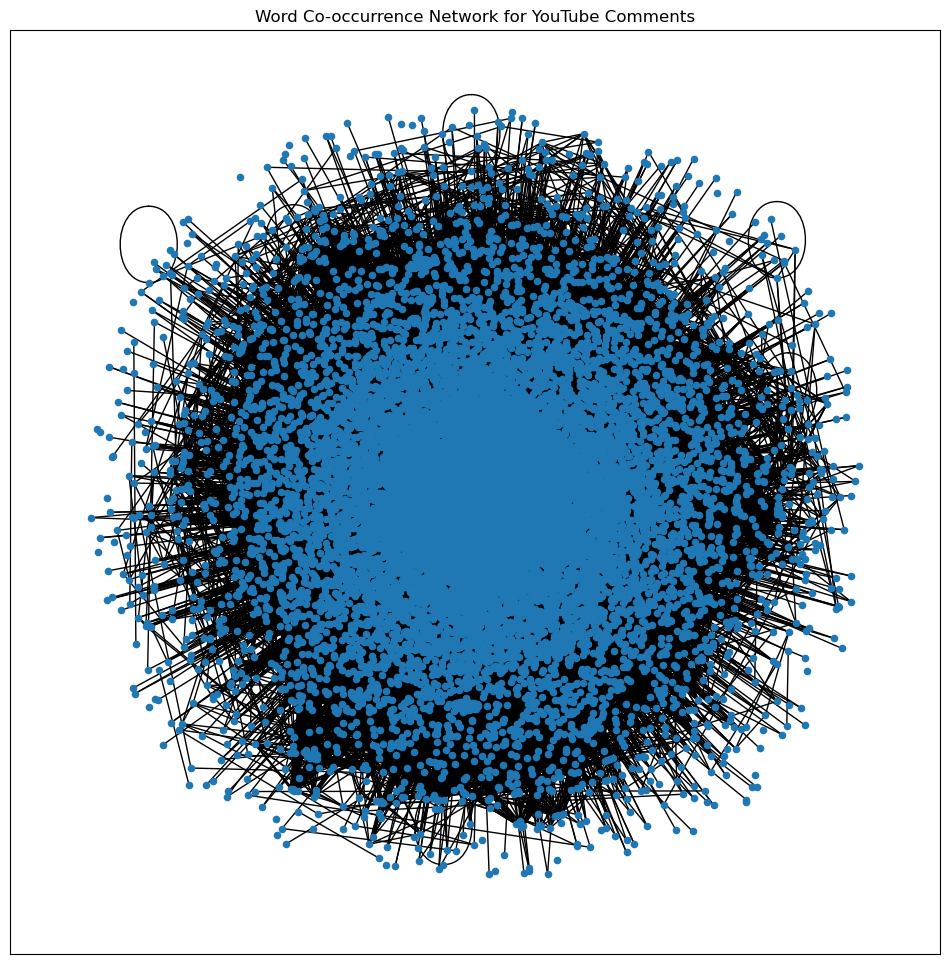

In [ ]:
# Visualize the network (Optional: May be large)
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.15)
nx.draw_networkx(G, pos=pos, with_labels=False, node_size=20, font_size=10)
plt.title('Word Co-occurrence Network for YouTube Comments')
plt.show()

#### Engagement Analysis

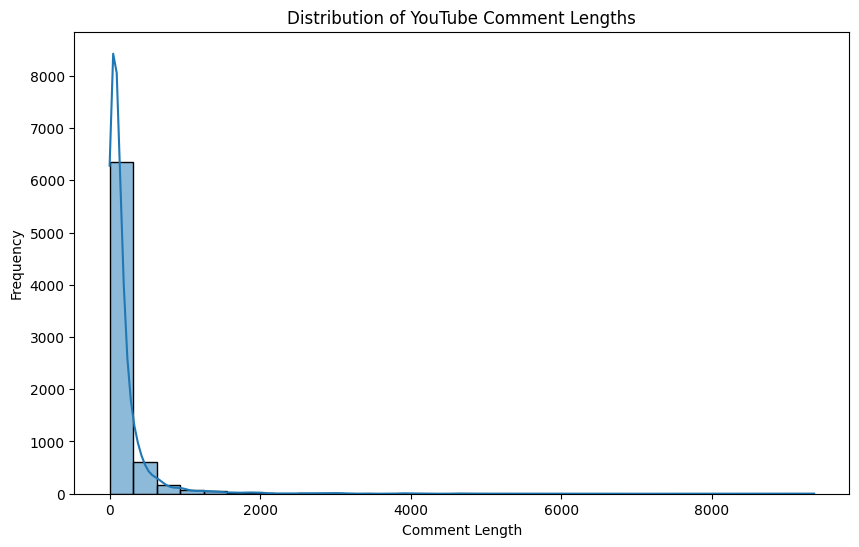

In [46]:
# Engagement Analysis
youtube_comments_df['comment_length'] = youtube_comments_df['comment_text'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(youtube_comments_df['comment_length'], bins=30, kde=True)
plt.title('Distribution of YouTube Comment Lengths')
plt.xlabel('Comment Length')
plt.ylabel('Frequency')
plt.show()

## Comparing Some Trends Between Reddit and YouTube

#### Sentiment Comparison

<ipython-input-47-cce8367de9f7>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(reddit_df['sentiment_score'], label='Reddit', shade=True)
<ipython-input-47-cce8367de9f7>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(youtube_comments_df['sentiment_score'], label='YouTube', shade=True)


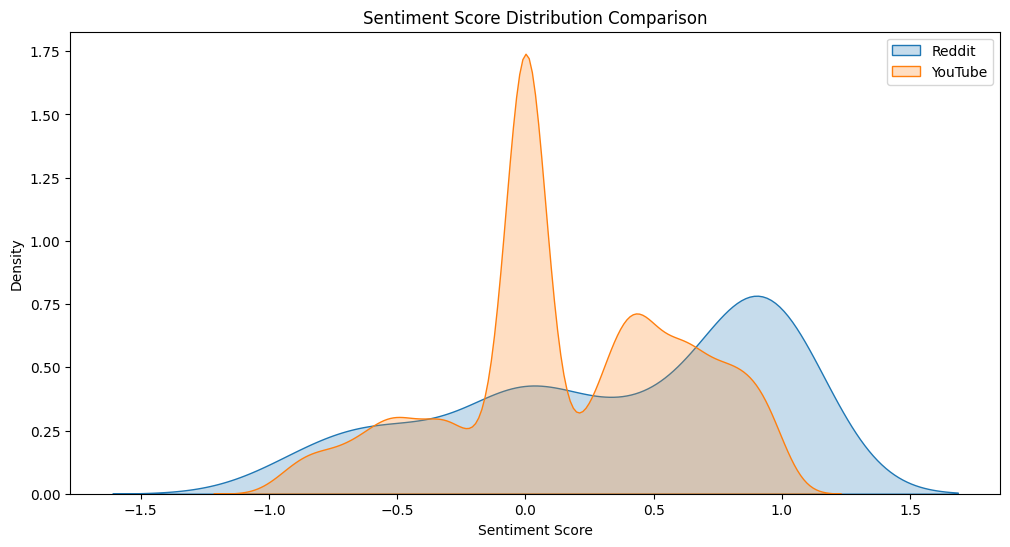

In [47]:
# Plotting Sentiment Distribution Comparison
plt.figure(figsize=(12, 6))
sns.kdeplot(reddit_df['sentiment_score'], label='Reddit', shade=True)
sns.kdeplot(youtube_comments_df['sentiment_score'], label='YouTube', shade=True)
plt.title('Sentiment Score Distribution Comparison')
plt.xlabel('Sentiment Score')
plt.legend()
plt.show()

#### Word Frequency Comparison

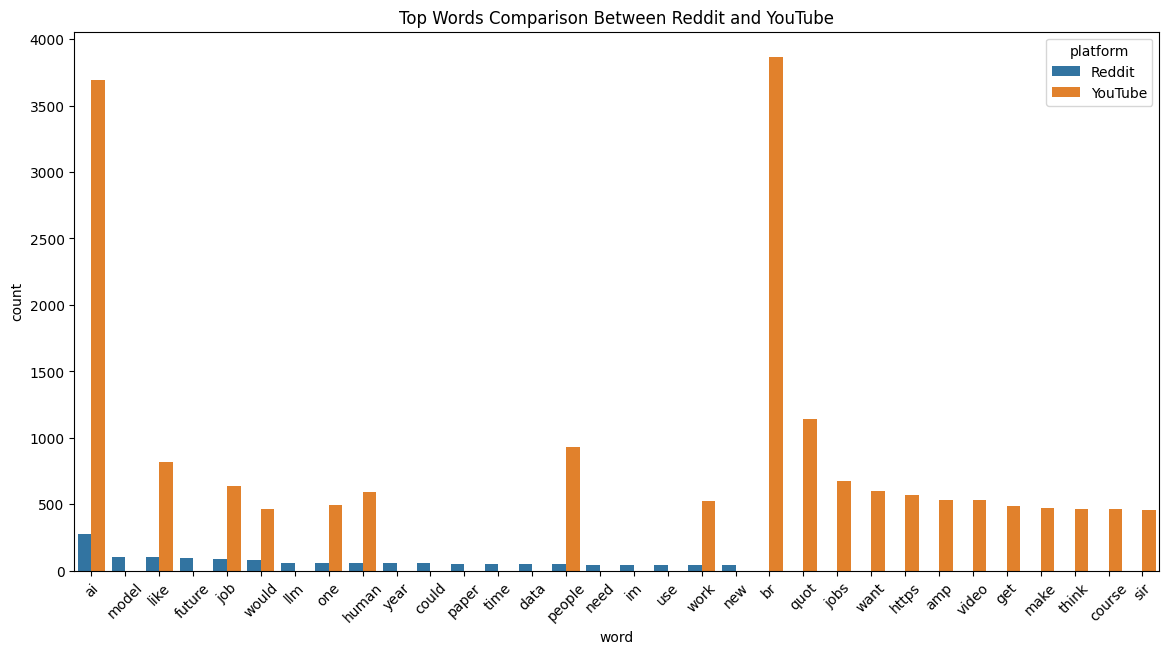

In [48]:
# Create DataFrames for word frequencies
reddit_word_freq_df = pd.DataFrame(reddit_common_words, columns=['word', 'count'])
reddit_word_freq_df['platform'] = 'Reddit'

youtube_word_freq_df = pd.DataFrame(youtube_common_words, columns=['word', 'count'])
youtube_word_freq_df['platform'] = 'YouTube'

# Combine DataFrames
word_freq_df = pd.concat([reddit_word_freq_df, youtube_word_freq_df])

# Plotting
plt.figure(figsize=(14, 7))
sns.barplot(x='word', y='count', hue='platform', data=word_freq_df)
plt.xticks(rotation=45)
plt.title('Top Words Comparison Between Reddit and YouTube')
plt.show()

#### Topic Comparison

Since the topics are generated separately, we can compare the top words in each topic for both platforms.

In [49]:
print("Comparing Top Words in Topics Between Reddit and YouTube")

# Reddit Topics
print("\nReddit Topics:")
for i, topic in enumerate(LDA.components_):
    topic_words = [vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-5:]]
    print(f"Topic #{i}: {', '.join(topic_words)}")

# YouTube Topics
print("\nYouTube Topics:")
for i, topic in enumerate(LDA.components_):
    topic_words = [vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-5:]]
    print(f"Topic #{i}: {', '.join(topic_words)}")

Comparing Top Words in Topics Between Reddit and YouTube

Reddit Topics:
Topic #0: learning, amp, course, https, br
Topic #1: amp, thanks, like, ai, br
Topic #2: ka, job, hai, sir, ai
Topic #3: human, jobs, people, quot, ai
Topic #4: good, job, like, video, ai

YouTube Topics:
Topic #0: learning, amp, course, https, br
Topic #1: amp, thanks, like, ai, br
Topic #2: ka, job, hai, sir, ai
Topic #3: human, jobs, people, quot, ai
Topic #4: good, job, like, video, ai


#### Additional

#### Word Overlap Between Platforms

Number of common words: 2804


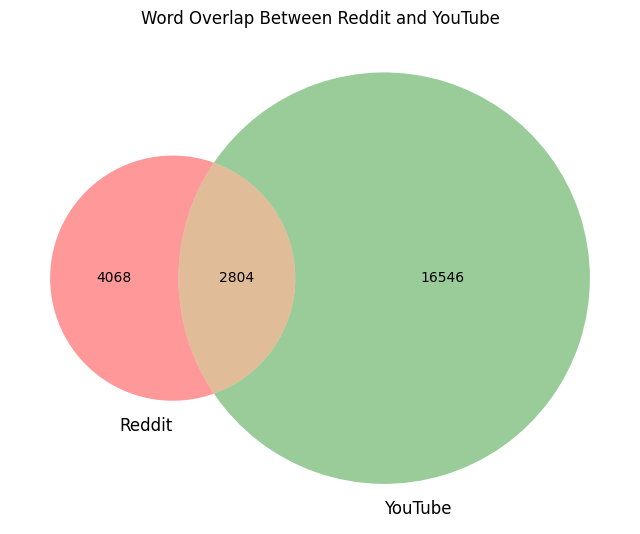

In [50]:
# Find common words between Reddit and YouTube
reddit_words_set = set(reddit_words)
youtube_words_set = set(youtube_words)

common_words = reddit_words_set.intersection(youtube_words_set)
print(f"Number of common words: {len(common_words)}")

# Plot Venn Diagram
from matplotlib_venn import venn2

plt.figure(figsize=(8, 8))
venn2(subsets=(len(reddit_words_set), len(youtube_words_set), len(common_words)), set_labels=('Reddit', 'YouTube'))
plt.title('Word Overlap Between Reddit and YouTube')
plt.show()

#### Correlation Between Engagement and Sentiment

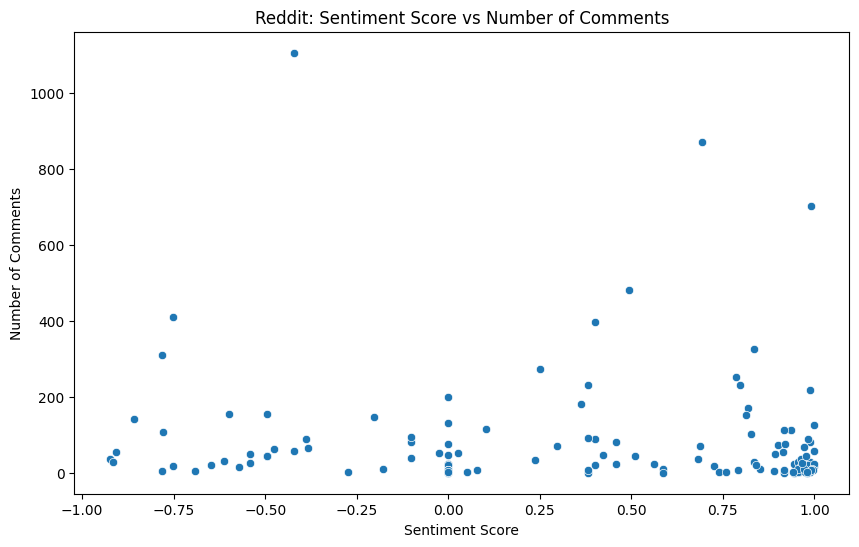

In [51]:
# Reddit
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sentiment_score', y='num_comments', data=reddit_df)
plt.title('Reddit: Sentiment Score vs Number of Comments')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Comments')
plt.show()

# YouTube
# Since we may not have engagement metrics, this is optional unless available

D.O

Qestions:

1. Word Frequency Analysis: Identify the most commonly used words on each platform. Are users discussing similar or different aspects of AI and future work?

2. Sentiment Analysis: Compare the overall sentiment on Reddit and YouTube. Is one platform more positive or negative about AI's impact on work?

3. Topic Modeling: Look at the main topics on each platform. Are there unique topics specific to Reddit or YouTube? What concerns or interests are prevalent?

4. Engagement Metrics: Analyze how engagement (e.g., number of comments, scores) correlates with sentiment or specific topics.

5. Social Network Analysis: Explore how words co-occur differently on each platform, indicating different discussions or narratives.

6. Time Series Analysis: (For Reddit) Observe how discussions evolve over time. Are there spikes in activity that correlate with news events or announcements?

To keep in mind:
1. Adjust Parameters: Need to adjust parameters like the number of topics in LDA models based the dataset.

# Sentiment Score Distribution Across Platforms

(array([ 3.,  1.,  5.,  1.,  2.,  4.,  4.,  2.,  2.,  0.,  1.,  2.,  3.,
         0., 19.,  2.,  1.,  0.,  2.,  1.,  9.,  2.,  2.,  3.,  0.,  5.,
         4.,  7.,  9., 36.]),
 array([-0.9248    , -0.86066333, -0.79652667, -0.73239   , -0.66825333,
        -0.60411667, -0.53998   , -0.47584333, -0.41170667, -0.34757   ,
        -0.28343333, -0.21929667, -0.15516   , -0.09102333, -0.02688667,
         0.03725   ,  0.10138667,  0.16552333,  0.22966   ,  0.29379667,
         0.35793333,  0.42207   ,  0.48620667,  0.55034333,  0.61448   ,
         0.67861667,  0.74275333,  0.80689   ,  0.87102667,  0.93516333,
         0.9993    ]),
 <BarContainer object of 30 artists>)

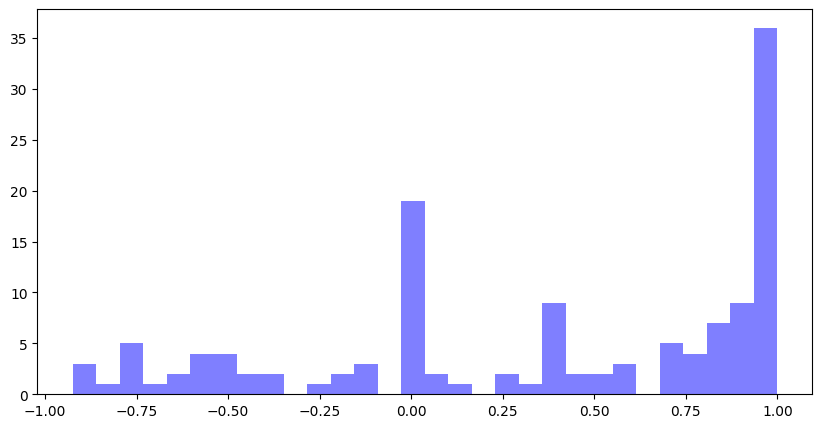

In [54]:
plt.figure(figsize=(10, 5))

plt.hist(reddit_df['sentiment_score'], bins=30, alpha=0.5, label='Reddit', color='blue')


In [62]:
# Drop rows with empty or missing comments
youtube_df = youtube_df[youtube_df['comments'].apply(lambda x: len(x) > 0)]


In [63]:
# Extract 'comment_text' from each dictionary in the comments list
def extract_comment_text(comment_list):
    if isinstance(comment_list, list):
        # Join all comment_text fields into one string
        return ' '.join([comment.get('comment_text', '') for comment in comment_list])
    return ''

# Apply the function to extract text into a new column
youtube_df['comments_text'] = youtube_df['comments'].apply(extract_comment_text)

# Verify the result
print(youtube_df[['comments', 'comments_text']].head())


                                             comments  \
8   [{'comment_text': '🎬 Check out the full video ...   
11  [{'comment_text': 'Bro send next session of fu...   
14  [{'comment_text': 'Nice video bro', 'author': ...   
18  [{'comment_text': 'Is AI-integrated coding cru...   
22  [{'comment_text': 'AI is simply a tool, but it...   

                                        comments_text  
8   🎬 Check out the full video here: <br><br><a hr...  
11  Bro send next session of full stack developmen...  
14                                     Nice video bro  
18  Is AI-integrated coding crucial for developers...  
22  AI is simply a tool, but it will never be an e...  


In [64]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Calculate sentiment scores for YouTube comments
youtube_df['sentiment_score'] = youtube_df['comments_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Verify the new column
print(youtube_df[['comments_text', 'sentiment_score']].head())


                                        comments_text  sentiment_score
8   🎬 Check out the full video here: <br><br><a hr...           0.0000
11  Bro send next session of full stack developmen...           0.6924
14                                     Nice video bro           0.4215
18  Is AI-integrated coding crucial for developers...           0.5719
22  AI is simply a tool, but it will never be an e...          -0.4782


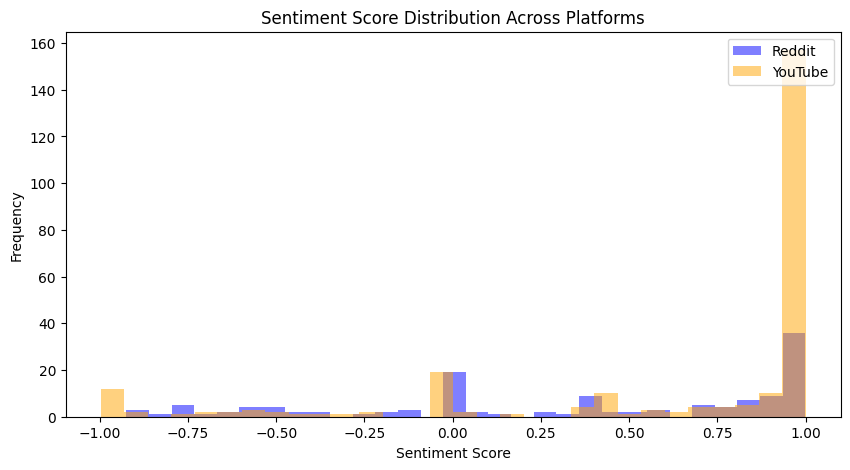

In [65]:
import matplotlib.pyplot as plt

# Plot sentiment distributions side by side
plt.figure(figsize=(10, 5))

plt.hist(reddit_df['sentiment_score'], bins=30, alpha=0.5, label='Reddit', color='blue')
plt.hist(youtube_df['sentiment_score'], bins=30, alpha=0.5, label='YouTube', color='orange')

plt.title('Sentiment Score Distribution Across Platforms')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()


In [66]:
youtube_df = youtube_df[youtube_df['comments_text'].str.strip() != '']


# Engagement vs. Sentiment Correlation:



In [69]:
# Create a 'comment_length' column as a proxy for engagement
youtube_df['comment_length'] = youtube_df['comments_text'].apply(len)

# Verify the new column
print(youtube_df[['comments_text', 'comment_length']].head())


                                        comments_text  comment_length
8   🎬 Check out the full video here: <br><br><a hr...             147
11  Bro send next session of full stack developmen...             680
14                                     Nice video bro              14
18  Is AI-integrated coding crucial for developers...              67
22  AI is simply a tool, but it will never be an e...              98


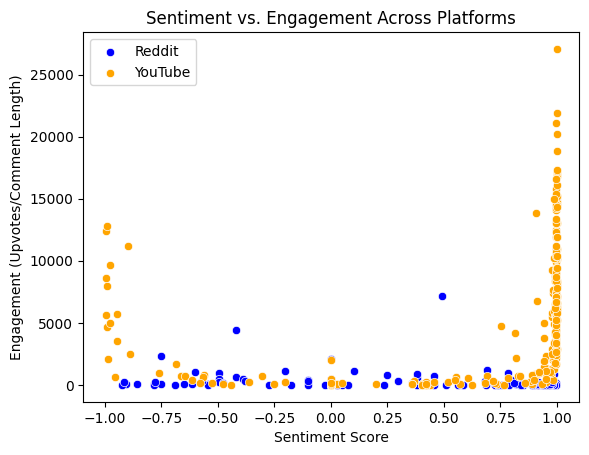

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot for Reddit and YouTube sentiment vs engagement
sns.scatterplot(data=reddit_df, x='sentiment_score', y='score', label='Reddit', color='blue')
sns.scatterplot(data=youtube_df, x='sentiment_score', y='comment_length', label='YouTube', color='orange')

# Add titles and labels
plt.title('Sentiment vs. Engagement Across Platforms')
plt.xlabel('Sentiment Score')
plt.ylabel('Engagement (Upvotes/Comment Length)')
plt.legend()
plt.show()


# Word Clouds for Frequent Topics


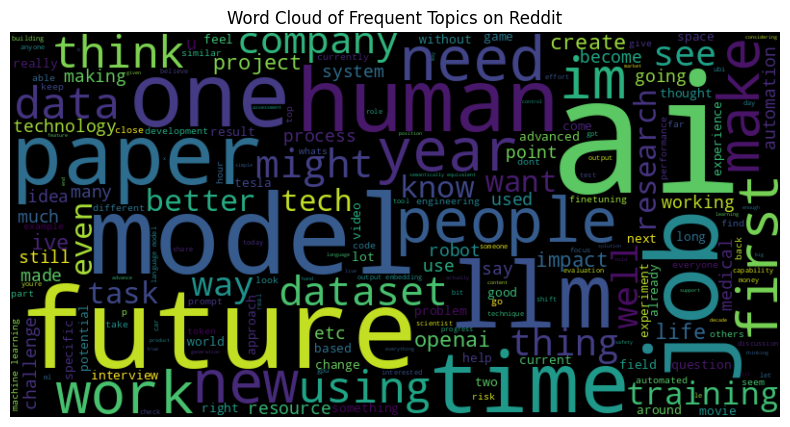

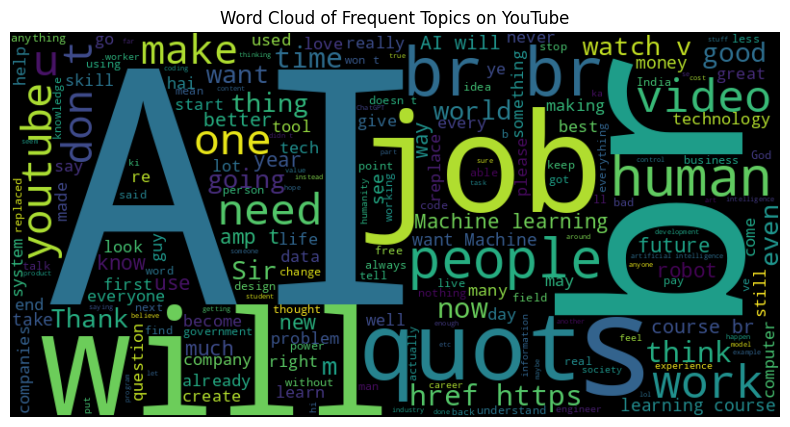

In [71]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Word cloud for Reddit comments
reddit_text = ' '.join(reddit_df['text'])
reddit_wordcloud = WordCloud(width=800, height=400).generate(reddit_text)

plt.figure(figsize=(10, 5))
plt.imshow(reddit_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Frequent Topics on Reddit')
plt.show()

# Word cloud for YouTube comments
youtube_text = ' '.join(youtube_df['comments_text'])
youtube_wordcloud = WordCloud(width=800, height=400).generate(youtube_text)

plt.figure(figsize=(10, 5))
plt.imshow(youtube_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Frequent Topics on YouTube')
plt.show()


# 4. Time-Series Sentiment Trend


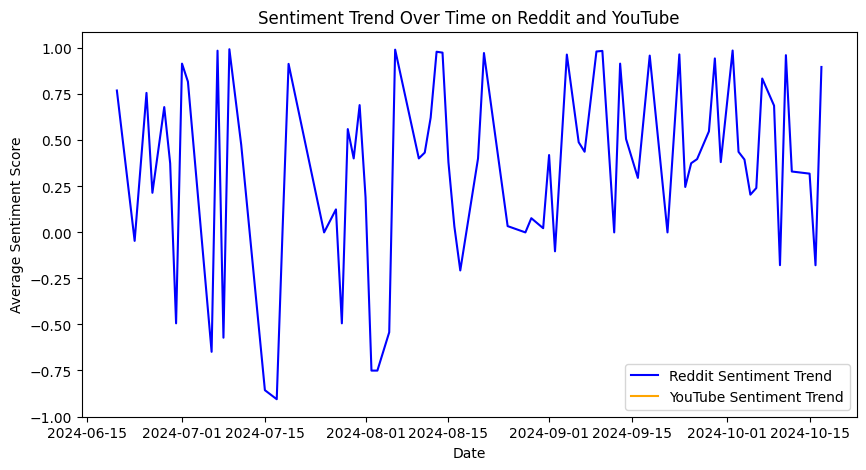

In [72]:
reddit_df['date'] = pd.to_datetime(reddit_df['created'])
youtube_df['date'] = pd.to_datetime(youtube_df['published_at'])

reddit_trend = reddit_df.groupby(reddit_df['date'].dt.date)['sentiment_score'].mean()
youtube_trend = youtube_df.groupby(youtube_df['date'].dt.date)['sentiment_score'].mean()

plt.figure(figsize=(10, 5))
plt.plot(reddit_trend, label='Reddit Sentiment Trend', color='blue')
plt.plot(youtube_trend, label='YouTube Sentiment Trend', color='orange')

plt.title('Sentiment Trend Over Time on Reddit and YouTube')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.legend()
plt.show()
